# Milestone 2 Sandbox

In [1]:
# Imports
import re
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## Data Description

### 2022 Voter Turnout File

This CSV file contains Census Block-level data on the number of people that registered to vote and that actually voted for 11 elections held in Massachusetts including the 2020 presidential election. The data also contains several fields for the demographics at that specific Census Block, including age brackets, gender, ethnicity, language spoken, and estimated mean household income. Finally, there is also information on the number of voters affiliated with each party.

The geoid20 field contains the ID of the Census Block. We can truncate this value and group the data to conduct our analysis at the Block Group, Tract, or County level. We can utilize this hierarchy to spatially visualize our data at these levels of details as well.

In the file, there is a total of 107,292 observations and 395 columns (not including geoid20). All demographic fields except mean household income contain no null values. There are 21,210 Census Blocks missing mean household income values. For this milestone, we consider voter turnout data only from the 2020 presidential election. There are around 20,000 observations with missing values for the percentage voter turnout in the Census Block. These values are missing because there are no voters registered for the 2020 presidential election in those Census Blocks. There are 301 Census Blocks with > 0 total registrations but with 0 registrations specifically for the 2020 presidential election.

There are 14 rows in the voter turnout file without Census Block IDs, included as entries with 'NO BLOCK ASSIGNMENT' in their geoid20 column. Aggregated, there are 73,811 registered voters not assigned to a Census Block. This represents 1.60% of total registered voters (4,606,321) in Massachusetts. The distribution of gender and party affiliation seems to be the same in observations with valid Census Block IDs and those with 'NO BLOCK ASSIGNMENT'. Age distribution differ slightly, with higher portion of people aged 25-44 with 'NO BLOCK ASSIGNMENT' and higher portion of people aged 45-75 with valid Census Block IDs.

### 2020 Census Block Shapefile

This Shapefile contains spatial data for Census Blocks. It contains 107,278 observations and 384 columns (not including GEOID20). For now, the shapefile is used to visualize the data on a map. With the exception of the 14 records with 'NO BLOCK ASSIGNMENT', the geoid20 field from the CSV perfectly matches with the GEOID20 field from the Shapefile.

## Potential Data Issues

## Solutions to Data Issues

## Supporting Code

### 2022 Voter Turnout File

In [2]:
# Read in the CSV file
voter_df = pd.read_csv('../data/MA_l2_2022stats_2020block/MA_l2_2022stats_2020block.csv').set_index('geoid20')
voter_df.shape

C:\Users\maxab\AppData\Local\Temp\ipykernel_43084\349142808.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  voter_df = pd.read_csv('../data/MA_l2_2022stats_2020block/MA_l2_2022stats_2020block.csv').set_index('geoid20')


(107292, 395)

In [3]:
# Group demographic columns together
registered = ['total_reg']
age = ['age_18_19', 'age_20_24', 'age_25_29','age_30_34','age_35_44', 'age_45_54', 'age_55_64', 'age_65_74','age_75_84', 'age_85over']
gender = [ 'voters_gender_m', 'voters_gender_f', 'voters_gender_unknown'] 
party = ['party_npp', 'party_dem', 'party_rep','party_lib', 'party_grn', 'party_con', 'party_ain', 'party_scl','party_oth', 'party_unk']
ethnicity = ['eth1_eur', 'eth1_hisp', 'eth1_aa',
                'eth1_esa', 'eth1_oth', 'eth1_unk', 'eth2_euro', 'eth2_64',
                'eth2_93', 'eth2_10', 'eth2_30', 'eth2_23', 'eth2_66', 'eth2_34',
                'eth2_21', 'eth2_35', 'eth2_14', 'eth2_12', 'eth2_55', 'eth2_13',
                'eth2_32', 'eth2_61', 'eth2_85', 'eth2_29', 'eth2_33', 'eth2_38',
                'eth2_15', 'eth2_57', 'eth2_19', 'eth2_26', 'eth2_59', 'eth2_unk']
languages = ['languages_description_english', 'languages_description_spanish',
                'languages_description_portuguese',
                'languages_description_chinese', 'languages_description_italian',
                'languages_description_vietnamese', 'languages_description_other',
                'languages_description_unknown']
income = ['commercialdata_estimatedhhincomeamount_avg']

# Group variables related to the 2020 presidential election
presidential_2020 = ['pp20200303_voted_all',
                     'pp20200303_reg_all', 'pp20200303_pct_voted_all',
                     'pp20200303_voted_gender_m', 'pp20200303_reg_gender_m',
                     'pp20200303_pct_voted_gender_m', 'pp20200303_voted_gender_f',
                     'pp20200303_reg_gender_f', 'pp20200303_pct_voted_gender_f',
                     'pp20200303_voted_gender_unk', 'pp20200303_reg_gender_unk',
                     'pp20200303_pct_voted_gender_unk', 'pp20200303_voted_eur',
                     'pp20200303_reg_eur', 'pp20200303_pct_voted_eur',
                     'pp20200303_voted_hisp', 'pp20200303_reg_hisp',
                     'pp20200303_pct_voted_hisp', 'pp20200303_voted_aa',
                     'pp20200303_reg_aa', 'pp20200303_pct_voted_aa',
                      'pp20200303_voted_esa', 'pp20200303_reg_esa',
                     'pp20200303_pct_voted_esa', 'pp20200303_voted_oth',
                     'pp20200303_reg_oth', 'pp20200303_pct_voted_oth',
                     'pp20200303_voted_unk', 'pp20200303_reg_unk',
                     'pp20200303_pct_voted_unk']

In [35]:
# Report null values for registered
voter_df[registered].isna().sum()

total_reg    0
dtype: int64

In [5]:
# Report null values for age
voter_df[age].isna().sum()

age_18_19     0
age_20_24     0
age_25_29     0
age_30_34     0
age_35_44     0
age_45_54     0
age_55_64     0
age_65_74     0
age_75_84     0
age_85over    0
dtype: int64

In [6]:
# Report null values for gender
voter_df[gender].isna().sum()

voters_gender_m          0
voters_gender_f          0
voters_gender_unknown    0
dtype: int64

In [7]:
# Report null values for gender
voter_df[party].isna().sum()

party_npp    0
party_dem    0
party_rep    0
party_lib    0
party_grn    0
party_con    0
party_ain    0
party_scl    0
party_oth    0
party_unk    0
dtype: int64

In [8]:
# Report null values for gender
voter_df[ethnicity].isna().sum()

eth1_eur     0
eth1_hisp    0
eth1_aa      0
eth1_esa     0
eth1_oth     0
eth1_unk     0
eth2_euro    0
eth2_64      0
eth2_93      0
eth2_10      0
eth2_30      0
eth2_23      0
eth2_66      0
eth2_34      0
eth2_21      0
eth2_35      0
eth2_14      0
eth2_12      0
eth2_55      0
eth2_13      0
eth2_32      0
eth2_61      0
eth2_85      0
eth2_29      0
eth2_33      0
eth2_38      0
eth2_15      0
eth2_57      0
eth2_19      0
eth2_26      0
eth2_59      0
eth2_unk     0
dtype: int64

In [9]:
# Report null values for income
voter_df[income].isna().sum()

commercialdata_estimatedhhincomeamount_avg    21210
dtype: int64

In [10]:
# Report null values for gender
voter_df[languages].isna().sum()

languages_description_english       0
languages_description_spanish       0
languages_description_portuguese    0
languages_description_chinese       0
languages_description_italian       0
languages_description_vietnamese    0
languages_description_other         0
languages_description_unknown       0
dtype: int64

In [11]:
# Report null values for presidential voter stats
voter_df[presidential_2020].isna().sum()

pp20200303_voted_all                   0
pp20200303_reg_all                     0
pp20200303_pct_voted_all           20783
pp20200303_voted_gender_m              0
pp20200303_reg_gender_m                0
pp20200303_pct_voted_gender_m      22171
pp20200303_voted_gender_f              0
pp20200303_reg_gender_f                0
pp20200303_pct_voted_gender_f      22032
pp20200303_voted_gender_unk            0
pp20200303_reg_gender_unk              0
pp20200303_pct_voted_gender_unk    99074
pp20200303_voted_eur                   0
pp20200303_reg_eur                     0
pp20200303_pct_voted_eur           22003
pp20200303_voted_hisp                  0
pp20200303_reg_hisp                    0
pp20200303_pct_voted_hisp          53915
pp20200303_voted_aa                    0
pp20200303_reg_aa                      0
pp20200303_pct_voted_aa            86742
pp20200303_voted_esa                   0
pp20200303_reg_esa                     0
pp20200303_pct_voted_esa           74286
pp20200303_voted

In [44]:
# Show Census Blocks with more than 0 total registrations but with 0 registrations in the 2020 presidential elections
voter_df[['total_reg','pp20200303_voted_all','pp20200303_reg_all']][(voter_df['total_reg'] > 0) & (voter_df['pp20200303_reg_all'] == 0)]

,total_reg,pp20200303_voted_all,pp20200303_reg_all
geoid20,,,
250277614022049,1,0,0
250277581041030,1,0,0
250277581031052,2,0,0
250277581031051,1,0,0
250277575001022,1,0,0
...,...,...,...
250010106004002,1,0,0
250010105003032,1,0,0
250010105002028,2,0,0


In [13]:
# Filter dataset to show entries without block IDs
no_block_df = voter_df[voter_df.index.str.contains('NO BLOCK',na=False)]
no_block_df.shape

(14, 395)

In [14]:
valid_df = voter_df.drop(no_block_df.index)
valid_df.shape

(107278, 395)

In [15]:
# Total number of people without block assignments
print(f'There are {no_block_df[registered].sum().iloc[0]:,d} registered voters not assigned to a Census Block.')
print(f'This represents {no_block_df[registered].sum().iloc[0]/voter_df[registered].sum().iloc[0]:.2%} ({voter_df[registered].sum().iloc[0]:,d}) of total registered voters in Massachusetts.')

There are 73,811 registered voters not assigned to a Census Block.
This represents 1.60% (4,606,321) of total registered voters in Massachusetts.


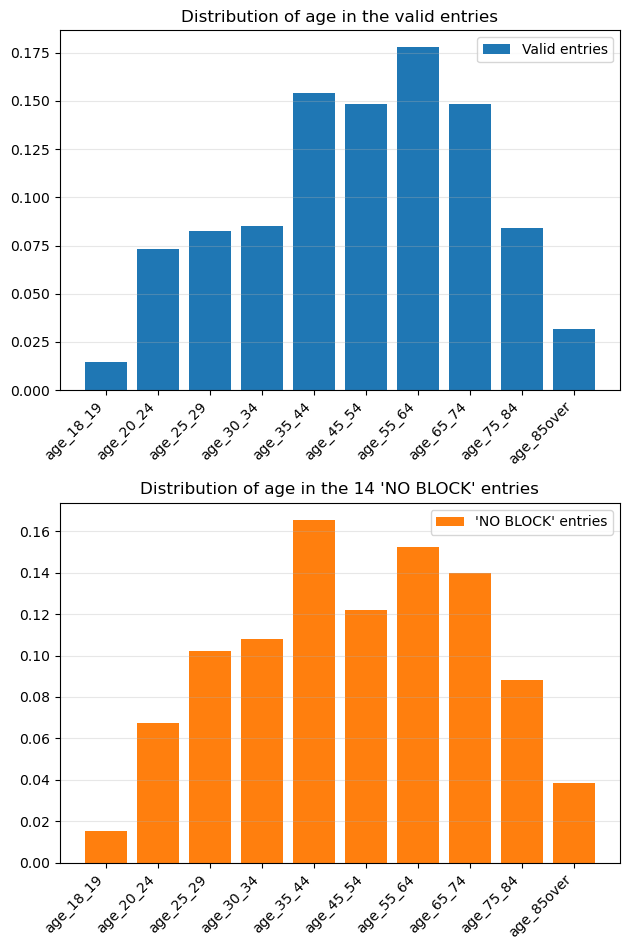

In [16]:
# Age distribution for those block assignments
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(6.4,4.8*2))
ax1.bar(age, valid_df[age].sum() / valid_df[registered].sum().iloc[0], color='C0', label='Valid entries')
ax1.set_xticks(ticks=age, labels=age, rotation=45, ha='right')
ax1.set_title('Distribution of age in the valid entries')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Age distribution for those without block assignments
ax2.bar(age, no_block_df[age].sum() / no_block_df[registered].sum().iloc[0], color='C1', label='\'NO BLOCK\' entries')
ax2.set_xticks(ticks=age, labels=age, rotation=45, ha='right')
ax2.set_title('Distribution of age in the 14 \'NO BLOCK\' entries')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

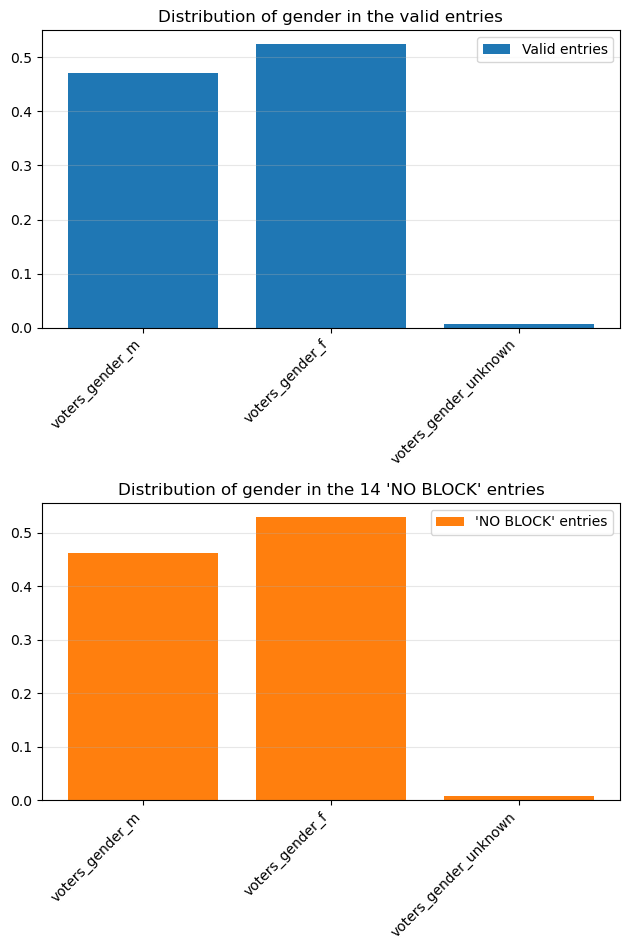

In [49]:
# party distribution for those block assignments
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(6.4,4.8*2))
ax1.bar(party, valid_df[party].sum() / valid_df[registered].sum().iloc[0], color='C0', label='Valid entries')
ax1.set_xticks(ticks=party, labels=party, rotation=45, ha='right')
ax1.set_title('Distribution of party in the valid entries')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# party distribution for those without block assignments
ax2.bar(party, no_block_df[party].sum() / no_block_df[registered].sum().iloc[0], color='C1', label='\'NO BLOCK\' entries')
ax2.set_xticks(ticks=party, labels=party, rotation=45, ha='right')
ax2.set_title('Distribution of party in the 14 \'NO BLOCK\' entries')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

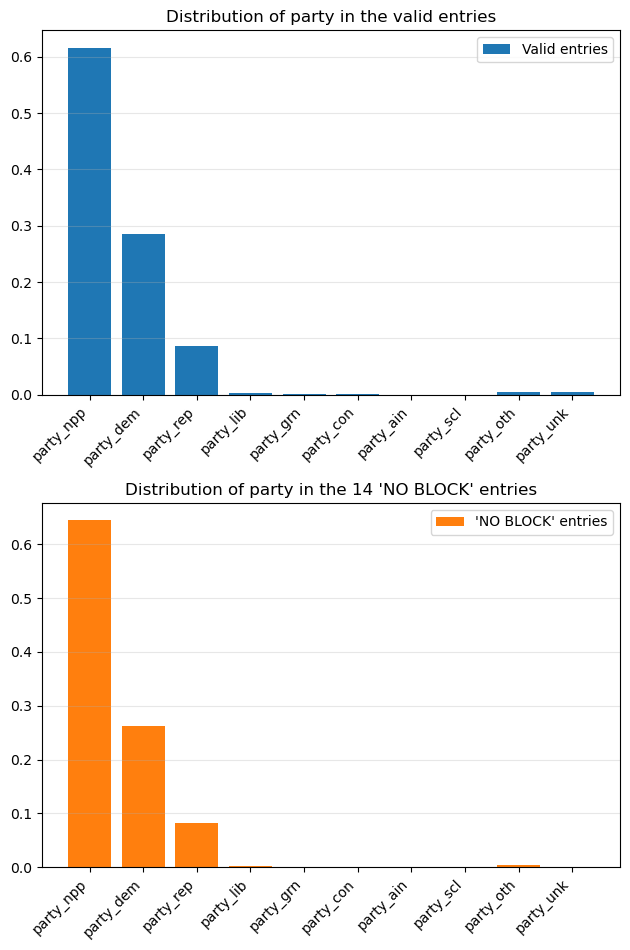

In [51]:
# party distribution for those block assignments
fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(6.4,4.8*2))
ax1.bar(party, valid_df[party].sum() / valid_df[registered].sum().iloc[0], color='C0', label='Valid entries')
ax1.set_xticks(ticks=party, labels=party, rotation=45, ha='right')
ax1.set_title('Distribution of party in the valid entries')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# party distribution for those without block assignments
ax2.bar(party, no_block_df[party].sum() / no_block_df[registered].sum().iloc[0], color='C1', label='\'NO BLOCK\' entries')
ax2.set_xticks(ticks=party, labels=party, rotation=45, ha='right')
ax2.set_title('Distribution of party in the 14 \'NO BLOCK\' entries')
ax2.grid(axis='y', alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

In [17]:
# Report the number of elections with data
elections = np.unique([col[:10].strip('_') for col in voter_df.columns if re.search(r'\w\d{8,9}',col[:10])])
print(f'There are {len(elections)} elections present in the dataset.')

There are 11 elections present in the dataset.


### 2020 Census Blocks Shapefile

In [18]:
# Read in the shapefile
blocks_gdf = gpd.read_file('../data/ma_pl2020_b/ma_pl2020_b.shp')
blocks_gdf.shape

(107278, 385)

In [19]:
# Print first 5 rows
blocks_gdf.head()

,STATEFP20,COUNTYFP20,TRACTCE20,BLOCKCE20,GEOID20,NAME20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,...,P0050002,P0050003,P0050004,P0050005,P0050006,P0050007,P0050008,P0050009,P0050010,geometry
0,25,003,935300,3056,250039353003056,Block 3056,G5040,S,5818,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-73.10996 42.69902, -73.10976 42.699..."
1,25,003,920102,1019,250039201021019,Block 1019,G5040,S,28305844,22648,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-73.23809 42.66205, -73.23797 42.662..."
2,25,003,926100,1041,250039261001041,Block 1041,G5040,S,228251,31171,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-73.41092 42.13063, -73.41082 42.131..."
3,25,003,931100,2021,250039311002021,Block 2021,G5040,S,63041,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-73.08619 42.70946, -73.08607 42.709..."
4,25,003,926100,1071,250039261001071,Block 1071,G5040,S,45386,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-73.32652 42.09883, -73.32633 42.098..."


In [20]:
# Merge the two files together with an outer join, see if any blocks are left out in each dataset
shape_blocks = blocks_gdf[['GEOID20']].copy()
shape_blocks['GEOID20'] = shape_blocks['GEOID20'].astype(str)
csv_blocks = voter_df.reset_index()[['geoid20']].copy()
csv_blocks['geoid20'] = csv_blocks['geoid20'].astype(str)
outer_merge = pd.merge(left=shape_blocks, right=csv_blocks, how='outer', left_on='GEOID20', right_on='geoid20')

In [21]:
# Confirm that discrepancy of 14 blocks are 'NO BLOCK ASSIGNMENT' entries
outer_merge[outer_merge['GEOID20'] != outer_merge['geoid20']]

,GEOID20,geoid20
0,NaN,001 - NO BLOCK ASSIGNMENT
1,NaN,003 - NO BLOCK ASSIGNMENT
2,NaN,005 - NO BLOCK ASSIGNMENT
3,NaN,007 - NO BLOCK ASSIGNMENT
4,NaN,009 - NO BLOCK ASSIGNMENT
5,NaN,011 - NO BLOCK ASSIGNMENT
6,NaN,013 - NO BLOCK ASSIGNMENT
7,NaN,015 - NO BLOCK ASSIGNMENT
8,NaN,017 - NO BLOCK ASSIGNMENT
9,NaN,019 - NO BLOCK ASSIGNMENT
